In [ ]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def check_and_install(package_name):
    try:
        __import__(package_name)
    except ImportError:
        os.system(f'pip install {package_name}')

check_and_install('gdown')

import matplotlib.pyplot as plt
import pathlib
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

# Dataset visualization

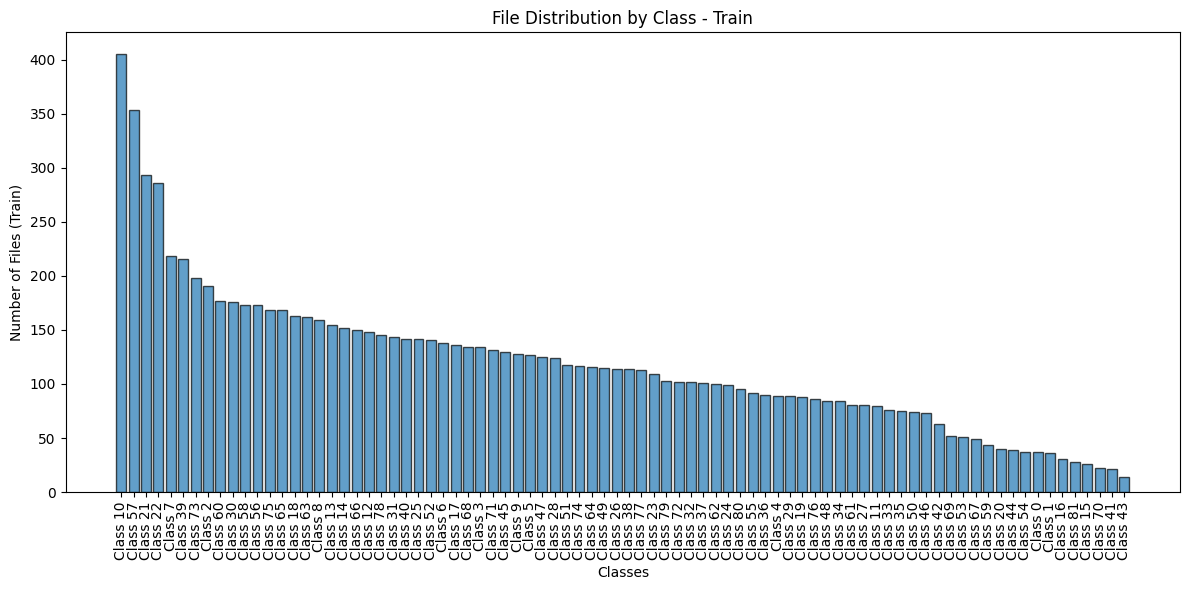

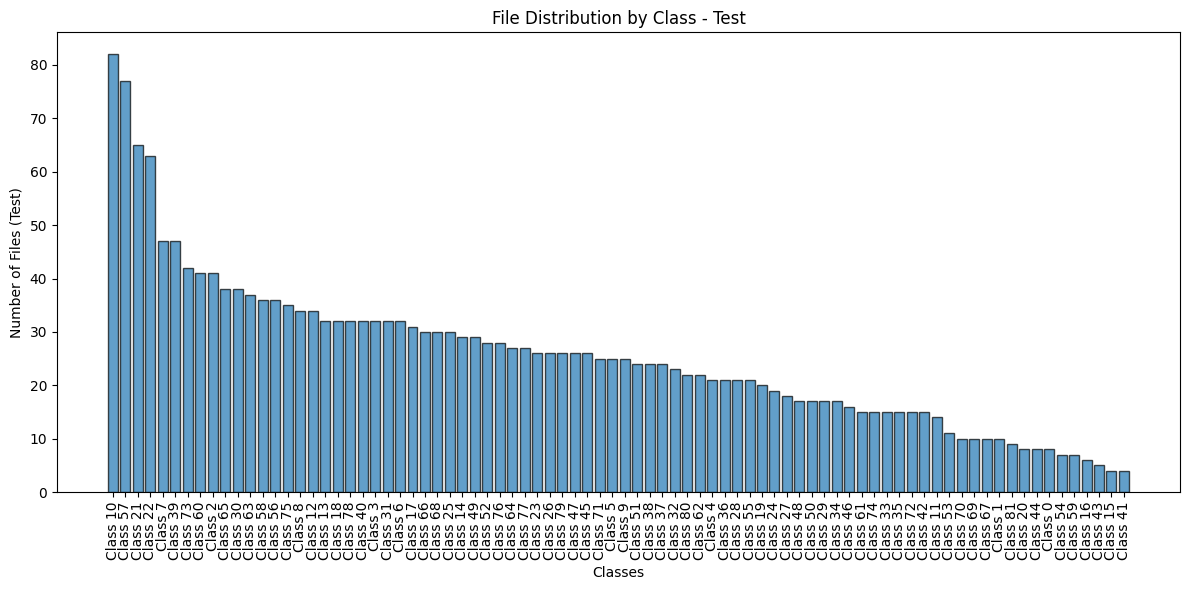

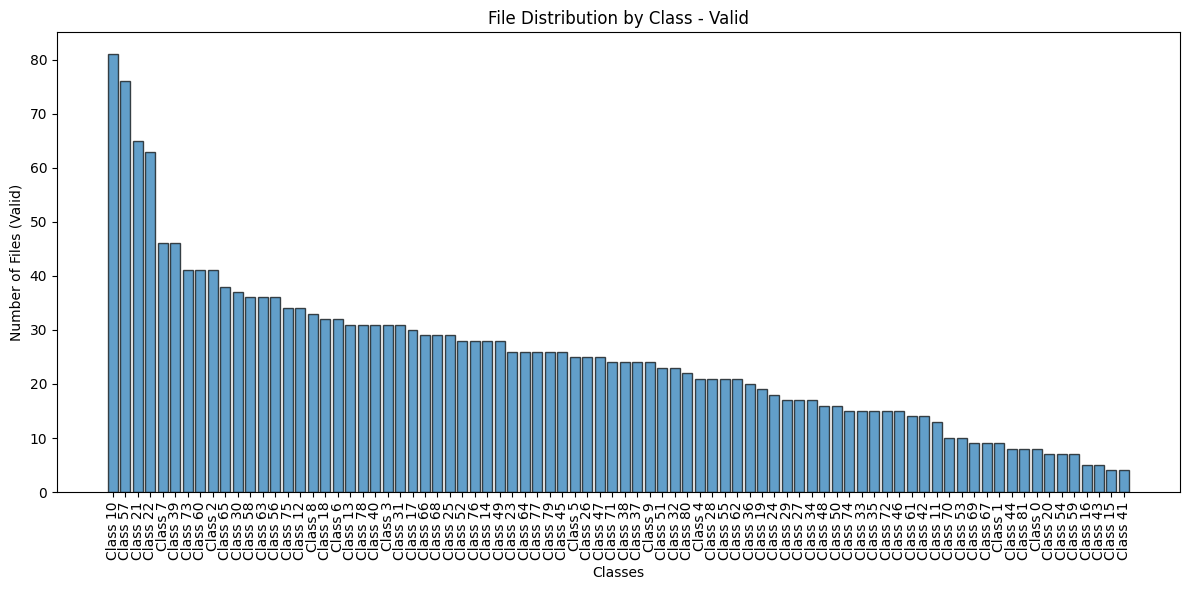


Contagem total por classe com nomes numerados e nomes reais (ordem alfabética):
Class 0 (Akarna_Dhanurasana): Train=37, Test=8, Valid=8, Total=53
Class 1 (Bharadvaja's_Twist_pose_or_Bharadvajasana_I_): Train=36, Test=10, Valid=9, Total=55
Class 2 (Boat_Pose_or_Paripurna_Navasana_): Train=191, Test=41, Valid=41, Total=273
Class 3 (Bound_Angle_Pose_or_Baddha_Konasana_): Train=134, Test=32, Valid=31, Total=197
Class 4 (Bow_Pose_or_Dhanurasana_): Train=89, Test=21, Valid=21, Total=131
Class 5 (Bridge_Pose_or_Setu_Bandha_Sarvangasana_): Train=127, Test=25, Valid=25, Total=177
Class 6 (Camel_Pose_or_Ustrasana_): Train=138, Test=32, Valid=32, Total=202
Class 7 (Cat_Cow_Pose_or_Marjaryasana_): Train=218, Test=47, Valid=46, Total=311
Class 8 (Chair_Pose_or_Utkatasana_): Train=159, Test=34, Valid=33, Total=226
Class 9 (Child_Pose_or_Balasana_): Train=128, Test=25, Valid=24, Total=177
Class 10 (Cobra_Pose_or_Bhujangasana_): Train=405, Test=82, Valid=81, Total=568
Class 11 (Cockerel_Pose): Train=

In [ ]:
def count_files_in_all_splits(dataset_path):
    """
    Counts the number of files in each class for the train, test, and valid directories.

    :param dataset_path: Path to the dataset (main directory).
    :return: Dictionary with the class name as the key and the number of files per split as values.
    """
    splits = ['train', 'test', 'valid']  # Main subdirectories
    class_counts = defaultdict(lambda: {'train': 0, 'test': 0, 'valid': 0})

    for split in splits:
        split_path = dataset_path / split
        if not split_path.exists():
            print(f"Subdirectory {split} not found in {dataset_path}")
            continue

        for class_name in os.listdir(split_path):
            class_path = split_path / class_name
            if class_path.is_dir():
                # Count the files in the class folder
                file_count = len([f for f in class_path.iterdir() if f.is_file()])
                class_counts[class_name][split] = file_count

    return class_counts

# Path to the dataset
dataset_path = pathlib.Path('kp_ds_not_aug_1')  # Modify to the correct path

# Download and unzip the dataset, if necessary
if not dataset_path.exists():
    os.system('gdown 1W6IaoG9Tvm_NDDZZiQ8Yc9Mc17D-_mfL -O dataset_keypoints_yoga.zip') # Drive ID
    os.system('unzip -q dataset_keypoints_yoga.zip')

# Count files in each class
class_file_counts = count_files_in_all_splits(dataset_path)

# Map classes to numbered names
class_name_map = {cls: f"Class {i}" for i, cls in enumerate(class_file_counts)}

# Generate histograms for each split with classes sorted in descending order by file count
for split in ['train', 'test', 'valid']:
    # Sort classes alphabetically to get the mapping
    sorted_class_names = sorted(class_file_counts.keys())  # Alphabetical order
    class_name_map = {cls: f"Class {i}" for i, cls in enumerate(sorted_class_names)}  # Numeric mapping

    # Sort classes by the number of files in the current subset
    sorted_classes_by_count = sorted(class_file_counts.items(), key=lambda x: x[1][split], reverse=True)

    # Map labels to the format "Class X (real_name)"
    classes = [class_name_map[cls] for cls, _ in sorted_classes_by_count]
    file_counts = [counts[split] for _, counts in sorted_classes_by_count]

    # Generate the histogram
    plt.figure(figsize=(12, 6))
    plt.bar(classes, file_counts, edgecolor='black', alpha=0.7)
    plt.xlabel("Classes")
    plt.ylabel(f"Number of Files ({split.capitalize()})")
    plt.title(f"File Distribution by Class - {split.capitalize()}")
    plt.xticks(rotation=90)  # Rotate class names for better readability
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

sorted_class_names = sorted(class_file_counts.keys())  # Sort real class names alphabetically
class_name_map = {cls: f"Class {i}" for i, cls in enumerate(sorted_class_names)}

# Display total counts with numbered and real names in alphabetical order
print("\nTotal count per class with numbered and real names (alphabetical order):")
for class_name in sorted_class_names:
    mapped_name = class_name_map[class_name]
    counts = class_file_counts[class_name]
    total = sum(counts.values())
    print(f"{mapped_name} ({class_name}): Train={counts['train']}, Test={counts['test']}, Valid={counts['valid']}, Total={total}")

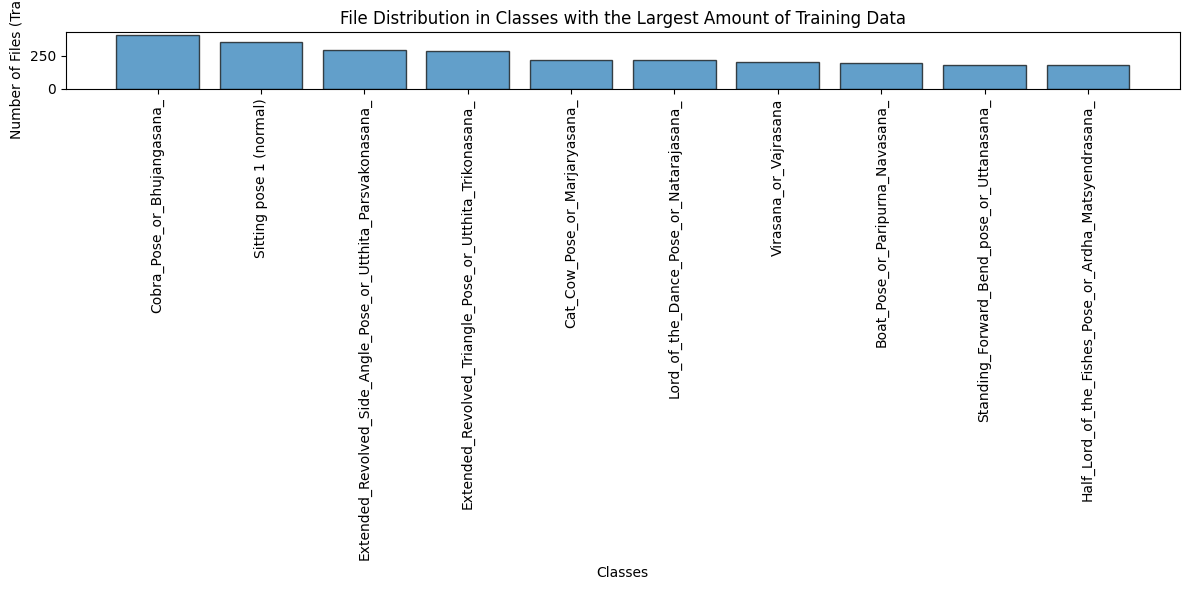


Number of training files in selected classes:
Cobra_Pose_or_Bhujangasana_: 405
Sitting pose 1 (normal): 353
Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana_: 293
Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_: 286
Cat_Cow_Pose_or_Marjaryasana_: 218
Lord_of_the_Dance_Pose_or_Natarajasana_: 216
Virasana_or_Vajrasana: 198
Boat_Pose_or_Paripurna_Navasana_: 191
Standing_Forward_Bend_pose_or_Uttanasana_: 177
Half_Lord_of_the_Fishes_Pose_or_Ardha_Matsyendrasana_: 176


In [ ]:
train_counts = {cls: counts['train'] for cls, counts in class_file_counts.items()}
sorted_train_classes = sorted(train_counts.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 classes with the largest amount of training data
top_classes = sorted_train_classes[:10]

# Display histograms only for the top 10 classes with the most data in the "train" split
top_class_names = [cls for cls, _ in top_classes]
file_counts = [class_file_counts[cls]['train'] for cls in top_class_names]

plt.figure(figsize=(12, 6))
plt.bar(top_class_names, file_counts, edgecolor='black', alpha=0.7)
plt.xlabel("Classes")
plt.ylabel("Number of Files (Train)")
plt.title("File Distribution in Classes with the Largest Amount of Training Data")
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

print("\nNumber of training files in selected classes:")
for cls, count in zip(top_class_names, file_counts):
    print(f"{cls}: {count}")

# Dataset preprocessing

In [ ]:
train_ds = tf.data.Dataset.list_files(str(dataset_path/'train/*/*.npy'), shuffle=True)

val_ds = tf.data.Dataset.list_files(str(dataset_path/'valid/*/*.npy'), shuffle=False)

test_ds = tf.data.Dataset.list_files(str(dataset_path/'test/*/*.npy'), shuffle=False)

In [6]:
def count_elements(dataset):
    count = 0
    for _ in dataset:
        count += 1
    return count

train_ds_count = count_elements(train_ds)
val_ds_count = count_elements(val_ds)
test_ds_count = count_elements(test_ds)

print(f"Tamanho do train_ds: {train_ds_count}")
print(f"Tamanho do val_ds: {val_ds_count}")
print(f"Tamanho do test_ds: {test_ds_count}")

Tamanho do train_ds: 9754
Tamanho do val_ds: 2051
Tamanho do test_ds: 2096


In [7]:
for f in train_ds.take(5):
    print(f.numpy())

b'kp_ds_not_aug_1/train/Cat_Cow_Pose_or_Marjaryasana_/1_447.npy'
b'kp_ds_not_aug_1/train/Locust_Pose_or_Salabhasana_/179.npy'
b'kp_ds_not_aug_1/train/Half_Lord_of_the_Fishes_Pose_or_Ardha_Matsyendrasana_/1_528.npy'
b'kp_ds_not_aug_1/train/Fish_Pose_or_Matsyasana_/181.npy'
b'kp_ds_not_aug_1/train/Supported_Headstand_pose_or_Salamba_Sirsasana_/351.npy'


In [8]:
class_names = np.array(sorted([item.name for item in dataset_path.glob('train/*')]))
class_names

array(['Akarna_Dhanurasana',
       "Bharadvaja's_Twist_pose_or_Bharadvajasana_I_",
       'Boat_Pose_or_Paripurna_Navasana_',
       'Bound_Angle_Pose_or_Baddha_Konasana_', 'Bow_Pose_or_Dhanurasana_',
       'Bridge_Pose_or_Setu_Bandha_Sarvangasana_',
       'Camel_Pose_or_Ustrasana_', 'Cat_Cow_Pose_or_Marjaryasana_',
       'Chair_Pose_or_Utkatasana_', 'Child_Pose_or_Balasana_',
       'Cobra_Pose_or_Bhujangasana_', 'Cockerel_Pose',
       'Corpse_Pose_or_Savasana_', 'Cow_Face_Pose_or_Gomukhasana_',
       'Crane_(Crow)_Pose_or_Bakasana_',
       'Dolphin_Plank_Pose_or_Makara_Adho_Mukha_Svanasana_',
       'Dolphin_Pose_or_Ardha_Pincha_Mayurasana_',
       'Downward-Facing_Dog_pose_or_Adho_Mukha_Svanasana_',
       'Eagle_Pose_or_Garudasana_', 'Eight-Angle_Pose_or_Astavakrasana_',
       'Extended_Puppy_Pose_or_Uttana_Shishosana_',
       'Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana_',
       'Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_',
       'Feathered

In [9]:
num_classes = len(class_names)
num_classes

82

## `tf.data` preprocessing

In [ ]:
def get_label(file_path):
    """
    Retrieves the label (class) from the file path.
    """
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

def decode_npy(file_path):
    """
    Loads data from a .npy file.
    """
    # Using tf.numpy_function to load the .npy file with numpy
    def load_npy(path):
        return np.load(path.decode('utf-8')).astype(np.float32)

    # Convert the path to a tensor using numpy_function
    npy_data = tf.numpy_function(load_npy, [file_path], tf.float32)
    npy_data.set_shape([33, 4])
    return npy_data

def process_path(file_path, label=None):
    """
    Processes the file path to obtain data and labels.
    """
    label = get_label(file_path)  # Retrieve label
    data = decode_npy(file_path)  # Load data from the .npy file
    return data, label

In [ ]:
# Dataset mapping
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
for input_batch, label_batch in train_ds.take(1):
    print(input_batch.shape)
    print(label_batch.numpy())

(33, 4)
7


In [ ]:
def configure_for_performance(ds, shuffle=False):
    """
    Configures the dataset for better performance during training.
    """
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


In [14]:
train_ds = configure_for_performance(train_ds, shuffle=True)
val_ds = configure_for_performance(val_ds, shuffle=False)
test_ds = configure_for_performance(test_ds, shuffle=False)

# Transformer with CNN extraction

## Transformer Encoder

In [15]:
init = HeUniform(seed=42)
reg1 = l2(1e-4)
reg2 = l2(1e-5)

In [ ]:
@tf.keras.utils.register_keras_serializable()
class TransformerEncoder(layers.Layer):
  def __init__(self, num_heads, conv_dim, name, **kwargs):
    super(TransformerEncoder, self).__init__(name=name, **kwargs)

    self.num_heads = num_heads
    self.conv_dim = conv_dim

    self.layer_norm = layers.LayerNormalization()
    self.mha = layers.MultiHeadAttention(self.num_heads, self.conv_dim,
                                         kernel_initializer=init)
    self.conv_proj = tf.keras.Sequential([
        layers.Dense(self.conv_dim, activation='relu', kernel_regularizer=reg1, bias_regularizer=reg1, activity_regularizer=reg2),
        layers.Dense(self.conv_dim, activation='relu', kernel_regularizer=reg1, bias_regularizer=reg1, activity_regularizer=reg2),
        layers.Dense(self.conv_dim, kernel_regularizer=reg1, bias_regularizer=reg1, activity_regularizer=reg2)
    ])

  def build(self, input_shape):
    super(TransformerEncoder, self).build(input_shape)

  def call(self, inputs):
    attention_output = self.mha(query=inputs, value=inputs, key=inputs)
    proj_input = self.layer_norm(inputs + attention_output)
    proj_output = self.conv_proj(proj_input)
    return self.layer_norm(proj_input + proj_output)

  def get_config(self):
    config = super().get_config()
    config.update({
        "num_heads": self.mha.num_heads,
        "conv_dim": self.mha.key_dim,
    })
    return config

## Model architecture


In [ ]:
input_shape = (33, 4)

inputs = tf.keras.Input(shape=input_shape)
x = layers.MultiHeadAttention(num_heads=4, key_dim=16)(inputs, inputs)
x = inputs + x
x = layers.Conv1D(filters=80, kernel_size=5, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv1D(filters=48, kernel_size=5, padding="same", kernel_regularizer=reg1)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv1D(filters=16, kernel_size=5, padding="same", kernel_regularizer=reg1, bias_regularizer=reg1, activity_regularizer=reg2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = TransformerEncoder(num_heads=4, conv_dim=16, name='transformer_encoder')(x)
x = layers.Flatten()(x)
x = layers.Dense(88, activation='relu', kernel_regularizer=reg1, bias_regularizer=reg1, activity_regularizer=reg2)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

transformer = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
transformer.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 33, 4)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 33, 4)          │          1,220 │ input_layer[0][0],     │
│ (MultiHeadAttention)      │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 33, 4)          │              0 │ input_layer[0][0],     │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 33, 80)         │          1,680 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 33, 80)         │            320 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 33, 80)         │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 33, 48)         │         19,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 33, 48)         │            192 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 33, 48)         │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 33, 48)         │              0 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 33, 16)         │          3,856 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 33, 16)         │             64 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 33, 16)         │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, 33, 16)         │          5,152 │ activation_2[0][0]     │
│ (TransformerEncoder)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 528)            │              0 │ transformer_encoder[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 88)             │         46,552 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)  

 Total params: 85,582 (334.30 KB)

 Trainable params: 85,294 (333.18 KB)

 Non-trainable params: 288 (1.12 KB)

## Model training

In [19]:
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * float(tf.math.exp(-0.1))

callbacks = [
    ModelCheckpoint(filepath='kp_ds_not_aug_1_model_1_tranformer_cnn.keras',
                    save_best_only=True,
                    monitor='val_accuracy',
                    verbose=1),
    LearningRateScheduler(scheduler),
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
]

In [20]:
transformer.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

In [21]:
history = transformer.fit(
    train_ds,
    epochs=150,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/150
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1240 - loss: 4.0771
Epoch 1: val_accuracy improved from -inf to 0.32618, saving model to kp_ds_not_aug_1_model_1_tranformer_cnn.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - accuracy: 0.1244 - loss: 4.0750 - val_accuracy: 0.3262 - val_loss: 2.7812 - learning_rate: 0.0010
Epoch 2/150
305/305 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4632 - loss: 2.1917
Epoch 2: val_accuracy improved from 0.32618 to 0.69868, saving model to kp_ds_not_aug_1_model_1_tranformer_cnn.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4633 - loss: 2.1911 - val_accuracy: 0.6987 - val_loss: 1.1775 - learning_rate: 0.0010
Epoch 3/150
304/305 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6053 - loss: 1.5897
Epoch 3: val_accuracy improved from 0.69868 to 0.78157, saving model to kp_ds_not_aug_1_model_1_tranformer_cnn.keras
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6054 - loss: 1.5893 - val_accuracy: 0.7816 - val_lo

## Model metrics

Average loss and accuracy during training:
loss: 0.7029 - accuracy: 83.55%
Model validation:
loss: 0.5912 - accuracy: 89.37%


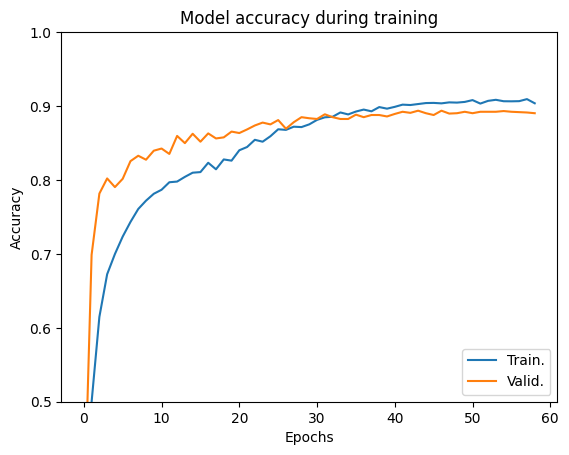

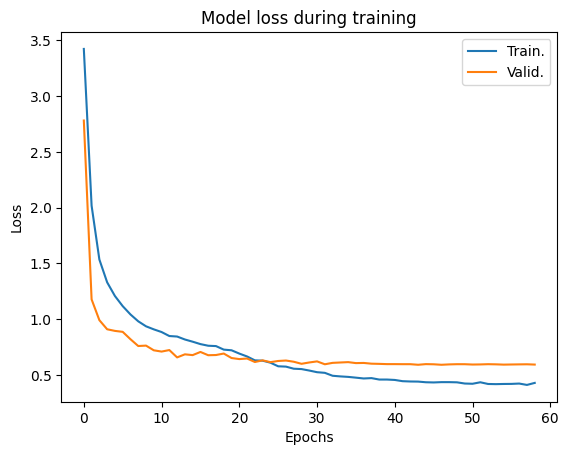

In [22]:
model = load_model("kp_ds_not_aug_1_model_1_tranformer_cnn.keras",
                   custom_objects={"TransformerEnconder": TransformerEncoder})

print("Average loss and accuracy during training:")
print(f"loss: {np.average(history.history['loss']):.4f} - accuracy: {np.average(history.history['accuracy']) * 100:.2f}%")

print("Model validation:")
scores = model.evaluate(val_ds, verbose=0)
print(f'loss: {scores[0]:.4f} - accuracy: {scores[1]* 100:.2f}%')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy during training')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train.', 'Valid.'], loc='lower right')
plt.ylim(0.5, 1.0)
plt.show()

print("\n")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train.', 'Valid.'], loc='upper right')
plt.show()

In [23]:
scores = model.evaluate(test_ds, verbose=0)
print("Model testing:")
print(f'loss: {scores[0]:.4f} - accuracy: {scores[1]* 100:.2f}%')

Model testing:
loss: 0.5618 - accuracy: 88.88%


In [ ]:
mapped_class_names = [class_name_map[cls] for cls in sorted_class_names]  # List of mapped class names

y_pred = np.argmax(model.predict(test_ds), axis=1)  # Get predictions based on probabilities
y_true = np.concatenate([label.numpy() for kp, label in test_ds], axis=0)  # Get true labels

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


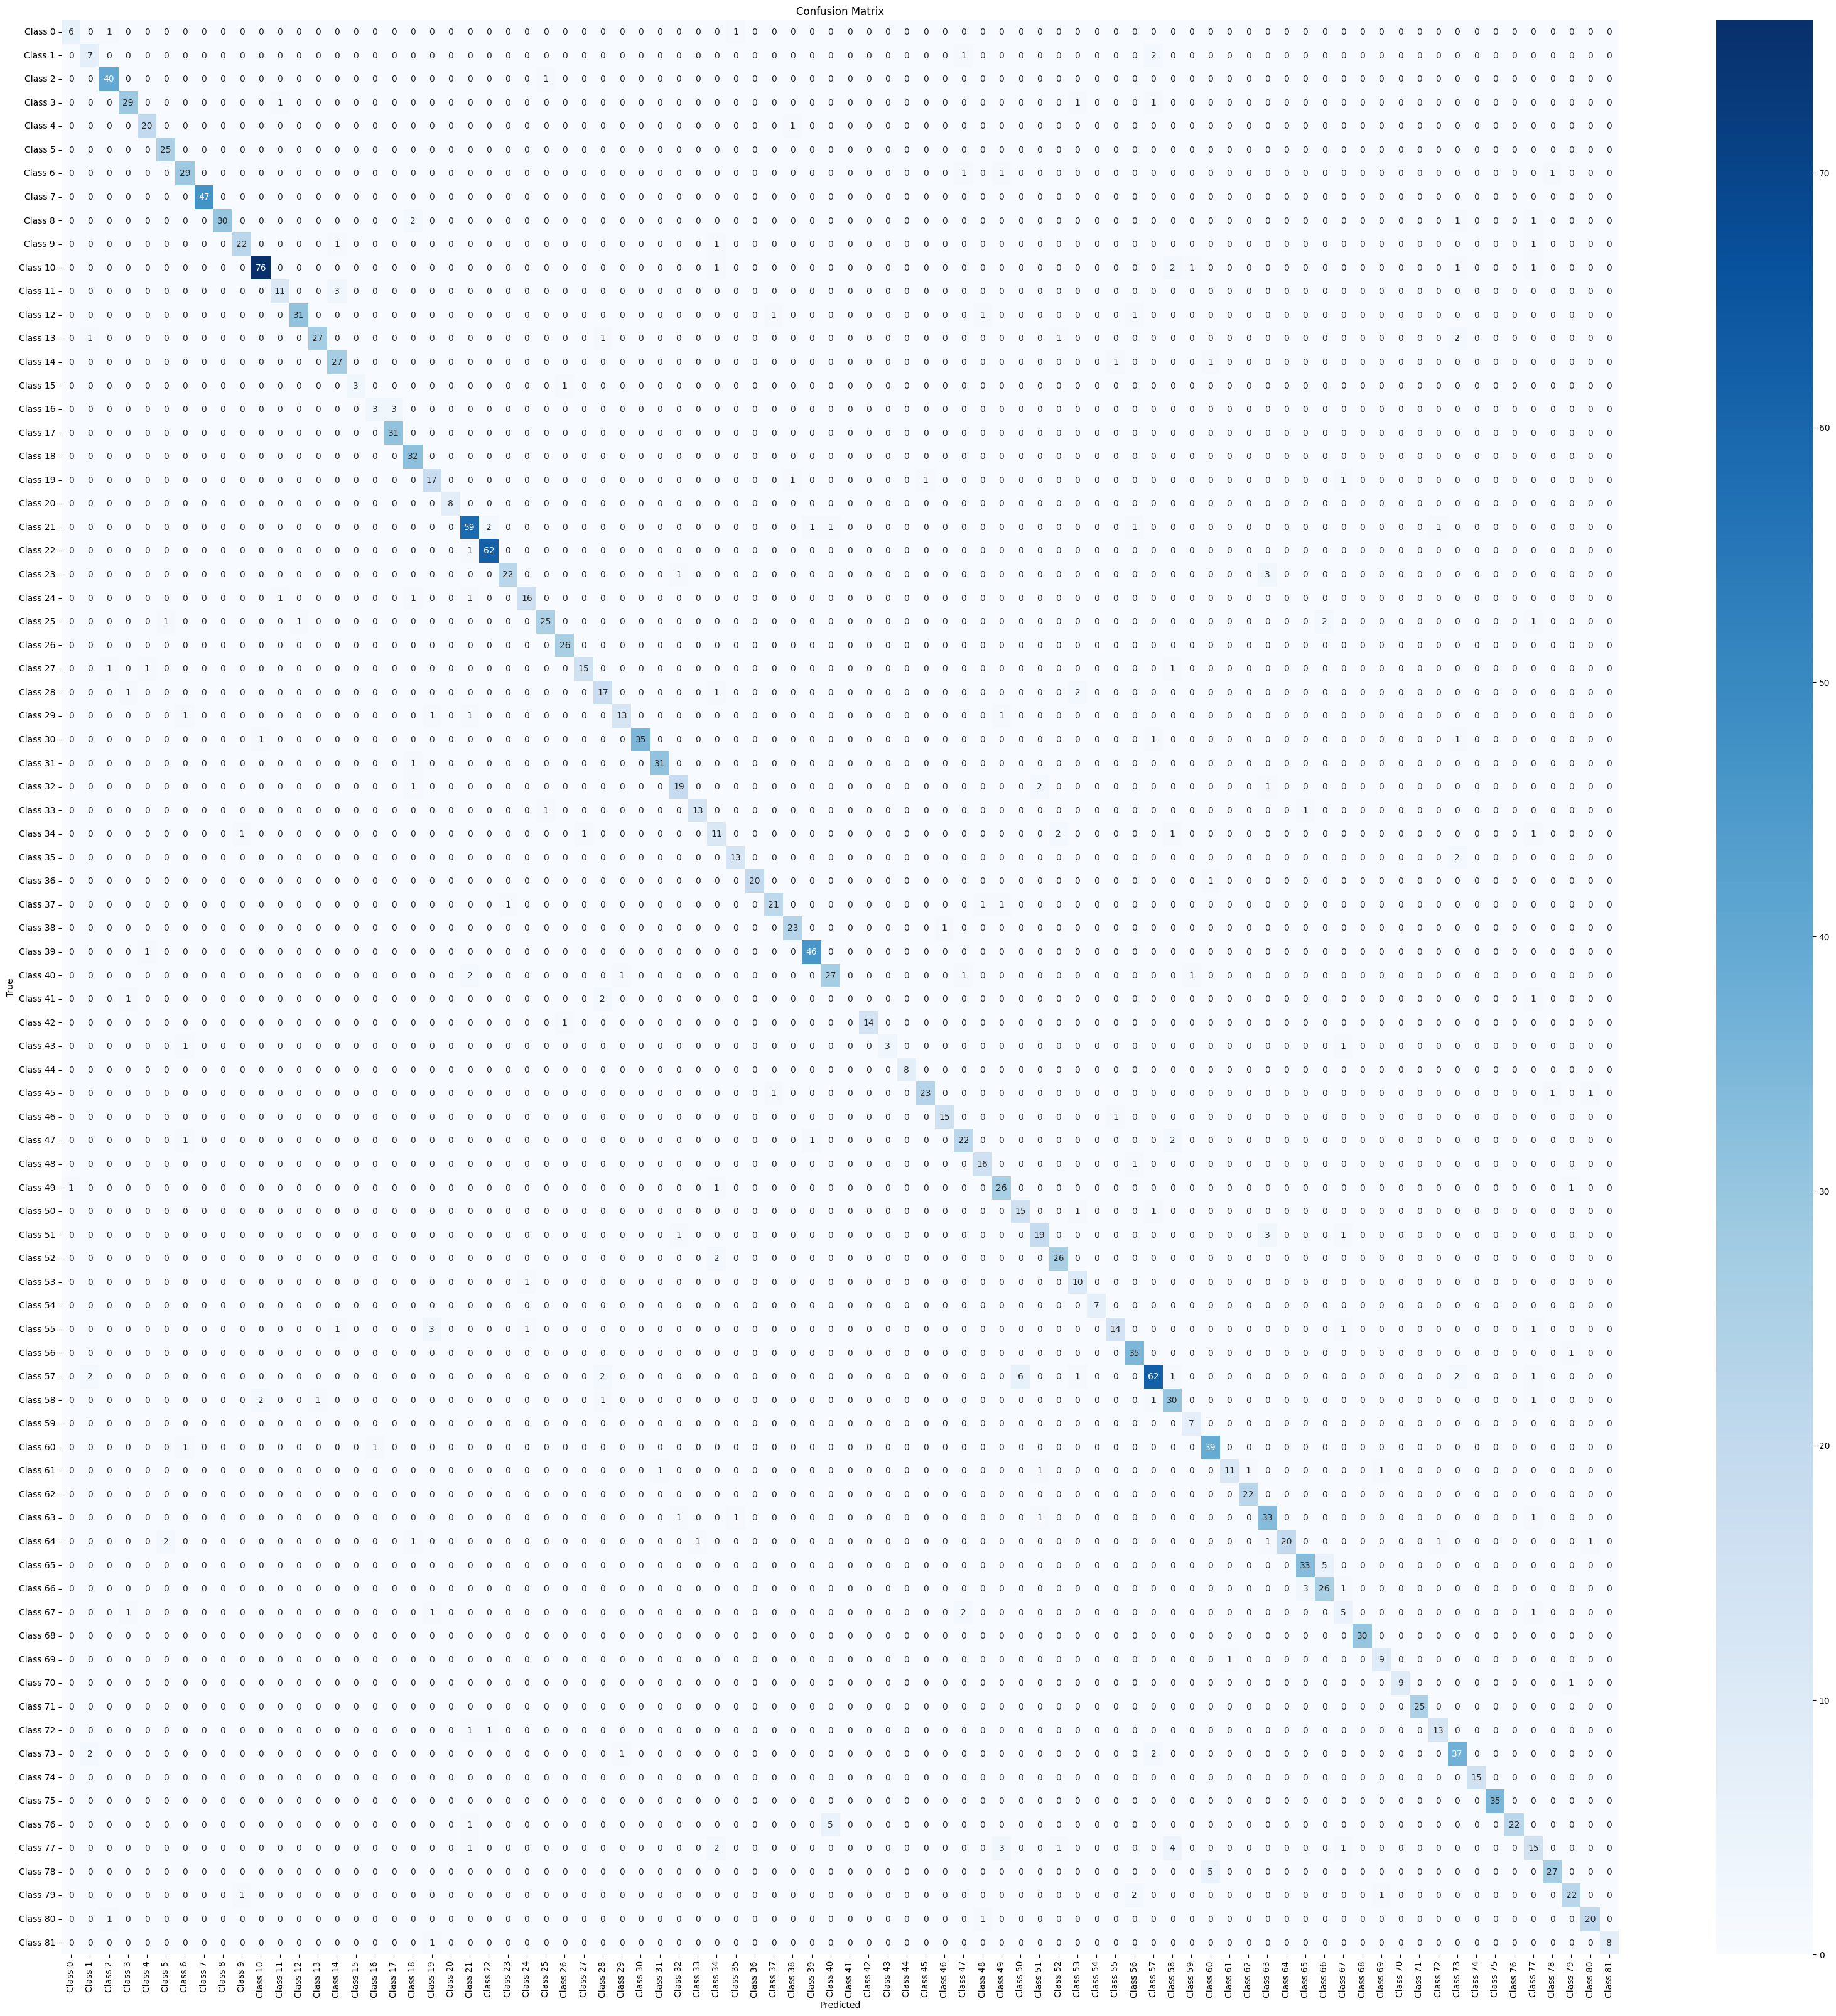

In [ ]:
# Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=mapped_class_names,
            yticklabels=mapped_class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification report
report = classification_report(y_true, y_pred, target_names=mapped_class_names, output_dict=True)
report_df = pd.DataFrame(report)
report_df.to_csv("kp_ds_not_aug_1_report_transformer.csv", index=True)
report_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9,...,Class 75,Class 76,Class 77,Class 78,Class 79,Class 80,Class 81,accuracy,macro avg,weighted avg
precision,0.857143,0.583333,0.930233,0.90625,0.909091,0.892857,0.878788,1.0,1.000000,0.916667,...,1.0,1.000000,0.576923,0.931034,0.880000,0.909091,1.000000,0.888836,0.873497,0.892078
recall,0.750000,0.700000,0.975610,0.90625,0.952381,1.000000,0.906250,1.0,0.882353,0.880000,...,1.0,0.785714,0.555556,0.843750,0.846154,0.909091,0.888889,0.888836,0.862620,0.888836
f1-score,0.800000,0.636364,0.952381,0.90625,0.930233,0.943396,0.892308,1.0,0.937500,0.897959,...,1.0,0.880000,0.566038,0.885246,0.862745,0.909091,0.941176,0.888836,0.864524,0.888152
support,8.000000,10.000000,41.000000,32.00000,21.000000,25.000000,32.000000,47.0,34.000000,25.000000,...,35.0,28.000000,27.000000,32.000000,26.000000,22.000000,9.000000,0.888836,2096.000000,2096.000000
